# 1. Import the necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 48

DIRECTORY = r"/content/drive/MyDrive/face mask detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


[INFO] loading images...


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 # 2. Perform one-hot encoding on the labels

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


# 3. Data Augmentation

In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


# 4. Loading Pretrained Model

In [6]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


# 5. Compiling the model

In [7]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 6. Training the model

In [8]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
46/46 [==============================] - 34s 542ms/step - loss: 0.5222 - accuracy: 0.7995 - val_loss: 0.2686 - val_accuracy: 0.9531
Epoch 2/20
46/46 [==============================] - 23s 504ms/step - loss: 0.2526 - accuracy: 0.9395 - val_loss: 0.1563 - val_accuracy: 0.9729
Epoch 3/20
46/46 [==============================] - 23s 509ms/step - loss: 0.1557 - accuracy: 0.9617 - val_loss: 0.1122 - val_accuracy: 0.9783
Epoch 4/20
46/46 [==============================] - 23s 497ms/step - loss: 0.1268 - accuracy: 0.9695 - val_loss: 0.0907 - val_accuracy: 0.9783
Epoch 5/20
46/46 [==============================] - 23s 499ms/step - loss: 0.1021 - accuracy: 0.9760 - val_loss: 0.0823 - val_accuracy: 0.9765
Epoch 6/20
46/46 [==============================] - 23s 496ms/step - loss: 0.1019 - accuracy: 0.9723 - val_loss: 0.0724 - val_accuracy: 0.9819
Epoch 7/20
46/46 [==============================] - 24s 512ms/step - loss: 0.0885 - accuracy: 0.9774 - val_loss: 0.067

# 7. Generating Prediction

In [9]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


[INFO] evaluating network...
12/12 [==============================] - 2s 95ms/step
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       262
without_mask       0.99      0.98      0.99       292

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554



# 8. Saving the model

In [10]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")



[INFO] saving mask detector model...


In [11]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

In [13]:
model.save('my_model.h5') 

# 9. Plotting the results

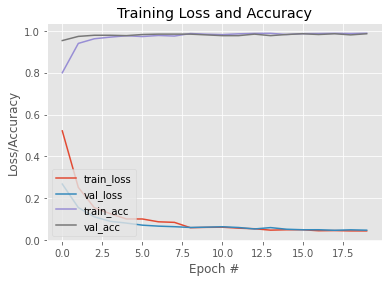

In [14]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")